In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn import metrics
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

%pylab inline
%config InlineBackend.figure_format = 'retina'

# Let's load a shared class that we will be using to persist the classifier
import sys
sys.path.append('../webservice/')
from classifier import ClassifyMessage

Populating the interactive namespace from numpy and matplotlib


**Settings**

In [2]:
n_of_folds=5

**Load the file**

In [3]:
df = pd.read_csv('dataset_for_assignment.csv.gz')
df.head(5)

,comment_text,target
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


**Check if the dataset is balanced**

In [4]:
df['target'].value_counts()

0    143346
1     16225
Name: target, dtype: int64

_... no, its not balanced_

**Tokenize and vectorize the file using TFIDF**

In [5]:
vectorizer = TfidfVectorizer(tokenizer = \
    RegexpTokenizer( \
        '[a-zA-Zа-яА-ЯёЁ]{2,}').tokenize, \
        max_features=10000, \
        stop_words='english')

X = vectorizer.fit_transform(df['comment_text'])

**Infer a logistic regression model on 5 folds**

In [6]:
model = LogisticRegression(solver='liblinear')

In [7]:
skf = StratifiedKFold(n_splits=n_of_folds)
roc_auc = []
for train_index, test_index in skf.split(X, df['target']):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = df['target'][train_index], df['target'][test_index]
    model.fit(X_train, y_train)
    predict = model.predict_proba(X_test)
    roc_auc.append(metrics.roc_auc_score(y_test, predict[:,1]))

In [8]:
print('ROC AUC: %.5f, stddev %.5f' % (np.mean(roc_auc), np.std(roc_auc)))

ROC AUC: 0.96802, stddev 0.00069


**Graph ROC AUC and precision-recall curves**

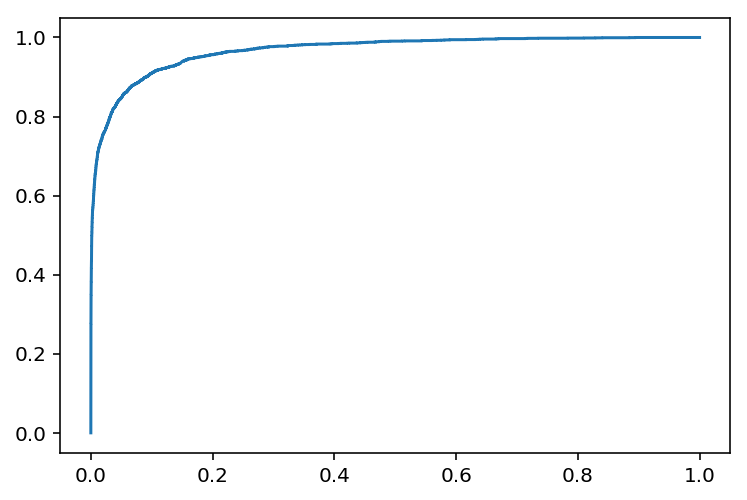

In [9]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predict[:, 1], pos_label=1)
plot(fpr, tpr)

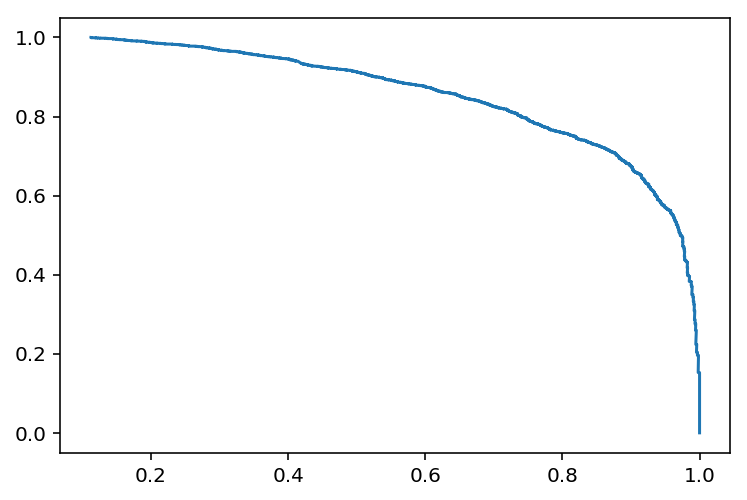

In [10]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, predict[:, 1])
plot(precision, recall)

**Find a threshold value that maximizes both precision and recall**

In [11]:
sorted(list(zip(precision, recall, thresholds)), key=lambda p: -(p[0] + p[1]) )[:5]

[(0.8764773160503241, 0.7084745762711865, 0.34144357417159893),
 (0.8767645936665395, 0.7081664098613251, 0.34163436201058045),
 (0.8761432926829268, 0.7084745762711865, 0.34131440995652323),
 (0.8764302059496567, 0.7081664098613251, 0.3416013233960609),
 (0.8767175572519084, 0.7078582434514638, 0.3420100244051313)]

**F1 score**

In [12]:
def f1(p): return (2*(p[0]*p[1])/(p[0]+p[1]))
sorted(list(zip(precision, recall, thresholds, [f1(p) for p in zip(precision, recall)])), key=f1, reverse=1 )[:1][0][2]

0.31686715009465866

**Compare the accuracy for the thresholds we just found to the default one - 0.5**

In [13]:
# default
metrics.accuracy_score(y_test, predict[:,1] >= 0.5)

0.956508115560569

In [14]:
# maximum sum of precision and recall
metrics.accuracy_score(y_test, predict[:,1] >= 0.34144357417159893)

0.9602055524221345

In [15]:
# maximum f1 score
metrics.accuracy_score(y_test, predict[:,1] >= 0.31686715009465866)

0.9598295418938397

In [22]:
sorted(zip(model.coef_[0], vectorizer.get_feature_names()), key=lambda p: -p[0])[:10]

[(16.30234483289418, 'fuck'),
 (13.560885052690983, 'fucking'),
 (12.032780499575662, 'shit'),
 (11.697450729214005, 'idiot'),
 (10.89356398983803, 'stupid'),
 (10.246434800587675, 'ass'),
 (9.614283401259895, 'bullshit'),
 (9.378489997540857, 'asshole'),
 (8.787197446367312, 'bitch'),
 (8.643001421796395, 'suck')]

**Save the model**

In [17]:
c = ClassifyMessage(model, vectorizer, 0.34144357417159893)
c.classify('ass idiot'), c.classify('some neutral text')

(True, False)

In [18]:
fn = 'model.pickle'
with open(fn, 'wb') as f:
    pickle.dump(c, f)

In [19]:
!ls -lh *pickle

-rw-r--r--+ 1 egor  _lpoperator   3.5M Mar 24 17:44 model.pickle


**Load and check if the classifier is working properly**

In [20]:
with open(fn, 'rb') as f:
    c2 = pickle.load(f)
    
c2.classify('ass idiot'), c2.classify('some neutral text')

(True, False)